In [1]:
import os
import json

import multiprocessing

import gc

import albumentations as albu
import cv2
import keras
from keras import backend as K
from keras.utils import Sequence
from keras.models import Model
from keras.layers import Input
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.optimizers import Adam, Nadam
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

!pip install segmentation-models --quiet
import segmentation_models as sm

from skimage.exposure import adjust_gamma

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
test_imgs_folder = '../input/understanding_cloud_organization/test_images/'
train_imgs_folder = '../input/understanding_cloud_organization/train_images/'
num_cpu_cores = multiprocessing.cpu_count()

In [3]:
train_df = pd.read_csv('/kaggle/input/understanding_cloud_organization/train.csv')
# Split Image_Label into ImageId and Label
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x : x.split('_')[0])
train_df['Label'] = train_df['Image_Label'].apply(lambda x : x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(22184, 5)


,Image_Label,EncodedPixels,ImageId,Label,hasMask
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,True
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,True
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel,False
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar,False
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,True


In [4]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(5546, 2)


,ImageId,hasMask
821,24dd99c.jpg,4.0
1885,562f80a.jpg,4.0
3260,944f10b.jpg,4.0
1872,55b539f.jpg,4.0
4464,cdf7242.jpg,4.0


In [5]:
train_ohe_df = train_df[~train_df['EncodedPixels'].isnull()]
classes = train_ohe_df['Label'].unique()
train_ohe_df = train_ohe_df.groupby('ImageId')['Label'].agg(set).reset_index()
for class_name in classes:
    train_ohe_df[class_name] = train_ohe_df['Label'].map(lambda x: 1 if class_name in x else 0)
print(train_ohe_df.shape)
train_ohe_df.head() 

(5546, 6)


,ImageId,Label,Fish,Flower,Sugar,Gravel
0,0011165.jpg,"{Fish, Flower}",1,1,0,0
1,002be4f.jpg,"{Fish, Flower, Sugar}",1,1,1,0
2,0031ae9.jpg,"{Fish, Flower, Sugar}",1,1,1,0
3,0035239.jpg,"{Flower, Gravel}",0,1,0,1
4,003994e.jpg,"{Fish, Sugar, Gravel}",1,0,1,1


In [6]:
# dictionary for fast access to ohe vectors
img_2_ohe_vector = {img:vec for img, vec in zip(train_ohe_df['ImageId'], train_df.iloc[:, 2:].values)}

In [7]:
submission_df = pd.read_csv('/kaggle/input/understanding_cloud_organization/sample_submission.csv')
submission_df['ImageId'] = submission_df['Image_Label'].apply(lambda x: x.split('_')[0])
test_images = pd.DataFrame(submission_df['ImageId'].unique(), columns=['ImageId'])

np_resize, build_masks, build_rles

In [8]:
def np_resize(img, input_shape):
    """
    Reshape a numpy array, which is input_shape=(height, width), 
    as opposed to input_shape=(width, height) for cv2
    """
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T
                                         
def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

LOSS FUNCTION

In [9]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(                intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

DATA Generator

In [10]:
BATCH_SIZE = 32
BACKBONE = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
EPOCHS = 50
# LEARNING_RATE = 1e-4
LEARNING_RATE = 0.002
HEIGHT = 320
WIDTH = 480
CHANNELS = 3
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
N_CLASSES = 4

In [11]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='../input/understanding_cloud_organization/train_images',
                 batch_size=BATCH_SIZE, dim=(1400, 2100), n_channels=CHANNELS, reshape=None,gamma=None,
                 augment=False, n_classes=4, random_state=42, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.gamma = gamma
        self.n_channels = n_channels
        self.augment = augment
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
#         self.graystyle = graystyle
        
        self.on_epoch_end()
        np.random.seed(self.random_state)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_rgb(img_path)
#             img = cv2.imread(img_path)
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             img = img.astype(np.float32) / 255.
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            
            # Adjust gamma
            if self.gamma is not None:
                img = adjust_gamma(img, gamma=self.gamma)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

    
    def __random_transform(self, img, masks):
        composition = albu.Compose([
            albu.HorizontalFlip(),
            albu.VerticalFlip(),
            albu.Rotate(limit=30),
            albu.GridDistortion()],p=1)
            
        
        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(
                img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch
    
    def get_labels(self):
        if self.shuffle:
            images_current = self.list_IDs[:self.len * self.batch_size]
            labels = [img_to_ohe_vector[img] for img in images_current]
        else:
            labels = self.labels
        return np.array(labels)   

In [12]:
train_idx, val_idx = train_test_split(train_ohe_df['ImageId'].index, 
                                        test_size=0.2, 
                                        stratify=train_ohe_df['Label'].map(lambda x: str(sorted(list(x)))), # sorting present classes in lexicographical order, just to be sure
                                        random_state=10)
# train_idx, val_idx = train_test_split(
#     mask_count_df.index, 
#     test_size=0.2,
#     random_state=10 
# )

In [13]:
train_generator = DataGenerator(train_idx, 
                                df=mask_count_df, 
                                target_df=train_df, 
                                batch_size=BATCH_SIZE,
                                reshape=(HEIGHT, WIDTH),
                                gamma=0.8,
                                augment=True,
#                                 graystyle=False,
                                shuffle = True,
                                n_channels=CHANNELS,
                                n_classes=N_CLASSES)
print("Train generator load")

val_generator = DataGenerator(val_idx, 
                              df=mask_count_df, 
                              target_df=train_df, 
                              batch_size=BATCH_SIZE, 
                              reshape=(HEIGHT, WIDTH),
                              gamma=0.8,
                              augment=False,
#                               graystyle=False,
                              shuffle = False,
                              n_channels=CHANNELS,
                              n_classes=N_CLASSES)
print("Validation generator load")


Train generator load
Validation generator load


In [14]:
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = 'elu'

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x

In [15]:
def Nest_Net(img_rows, img_cols, color_type=1, num_class=1, deep_supervision=False):

    nb_filter = [32,64,128,256,512]
    act = 'elu'

    bn_axis = 3
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(img_input, [nestnet_output_1,nestnet_output_2,nestnet_output_3,nestnet_output_4])
    else:
        model = Model(img_input, [nestnet_output_4])
    
    return model

In [16]:
def unet(input_shape):

    inputs = Input(input_shape)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2), padding='same') (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2), padding='same') (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2), padding='same') (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D((2, 2), padding='same') (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D((2, 2), padding='same') (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [17]:
earlystopping = EarlyStopping(monitor='val_loss', 
                             mode='min', 
                             patience=ES_PATIENCE,
                             restore_best_weights=True,
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              mode='min',
                              patience=RLROP_PATIENCE,
                              factor=DECAY_DROP,
                              min_lr=1e-6,
                              verbose=1)

metric_list = [dice_coef]
callback_list = [earlystopping, reduce_lr]
optimizer = Adam(lr = LEARNING_RATE)

# model = unet((HEIGHT,WIDTH,CHANNELS))
model = sm.Unet(
    BACKBONE, 
    classes=N_CLASSES,
    input_shape=(HEIGHT, WIDTH, CHANNELS),
    activation=ACTIVATION
)

model.compile(optimizer=optimizer, 
              loss=bce_dice_loss, 
              metrics=metric_list)

model.summary()

44924928/44920640 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 320, 480, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 326, 486, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 160, 240, 64) 9408        zero_padding2d_1[0][0]           
___________________________

In [18]:
checkpoint = ModelCheckpoint('model.h5', save_best_only=True)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, earlystopping, reduce_lr],
    epochs=EPOCHS,
#     epochs=2,
    verbose=1
)

Epoch 1/50
138/138 [==============================] - 862s 6s/step - loss: 0.9604 - dice_coef: 0.4160 - val_loss: 61.0792 - val_dice_coef: 0.2029
Epoch 2/50
138/138 [==============================] - 781s 6s/step - loss: 0.8765 - dice_coef: 0.4690 - val_loss: 10.8210 - val_dice_coef: 0.2394
Epoch 3/50
138/138 [==============================] - 758s 5s/step - loss: 0.8484 - dice_coef: 0.4862 - val_loss: 8.4629 - val_dice_coef: 0.2022
Epoch 4/50
138/138 [==============================] - 767s 6s/step - loss: 0.8382 - dice_coef: 0.4936 - val_loss: 2.9331 - val_dice_coef: 0.2277
Epoch 5/50
138/138 [==============================] - 766s 6s/step - loss: 0.8269 - dice_coef: 0.5004 - val_loss: 3.8755 - val_dice_coef: 0.2424
Epoch 6/50
138/138 [==============================] - 784s 6s/step - loss: 0.8214 - dice_coef: 0.5034 - val_loss: 1.4572 - val_dice_coef: 0.1946
Epoch 7/50
138/138 [==============================] - 770s 6s/step - loss: 0.8104 - dice_coef: 0.5097 - val_loss: 2.0474 - val_d

/opt/conda/lib/python3.6/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 32 could not be retrieved. It could be because a worker has died.
  UserWarning)


138/138 [==============================] - 815s 6s/step - loss: 0.8050 - dice_coef: 0.5133 - val_loss: 1.2287 - val_dice_coef: 0.3878
Epoch 9/50
138/138 [==============================] - 751s 5s/step - loss: 0.8042 - dice_coef: 0.5144 - val_loss: 1.1626 - val_dice_coef: 0.4264
Epoch 10/50
138/138 [==============================] - 771s 6s/step - loss: 0.8021 - dice_coef: 0.5158 - val_loss: 1.0485 - val_dice_coef: 0.4725
Epoch 11/50
138/138 [==============================] - 761s 6s/step - loss: 0.7942 - dice_coef: 0.5206 - val_loss: 1.1879 - val_dice_coef: 0.4549
Epoch 12/50
138/138 [==============================] - 778s 6s/step - loss: 0.7903 - dice_coef: 0.5221 - val_loss: 0.9992 - val_dice_coef: 0.4695
Epoch 13/50
138/138 [==============================] - 753s 5s/step - loss: 0.7883 - dice_coef: 0.5229 - val_loss: 0.8511 - val_dice_coef: 0.5219
Epoch 14/50
138/138 [==============================] - 765s 6s/step - loss: 0.7857 - dice_coef: 0.5249 - val_loss: 0.8811 - val_dice_coef

/opt/conda/lib/python3.6/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 128 could not be retrieved. It could be because a worker has died.
  UserWarning)


138/138 [==============================] - 818s 6s/step - loss: 0.7529 - dice_coef: 0.5450 - val_loss: 0.9246 - val_dice_coef: 0.5264
Epoch 23/50
138/138 [==============================] - 755s 5s/step - loss: 0.7476 - dice_coef: 0.5490 - val_loss: 0.8336 - val_dice_coef: 0.5301

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 24/50
138/138 [==============================] - 774s 6s/step - loss: 0.7366 - dice_coef: 0.5545 - val_loss: 0.7483 - val_dice_coef: 0.5391
Epoch 25/50
138/138 [==============================] - 776s 6s/step - loss: 0.7349 - dice_coef: 0.5561 - val_loss: 0.8048 - val_dice_coef: 0.5237
Epoch 26/50
138/138 [==============================] - 763s 6s/step - loss: 0.7319 - dice_coef: 0.5579 - val_loss: 0.8316 - val_dice_coef: 0.5376
Epoch 27/50
138/138 [==============================] - 743s 5s/step - loss: 0.7297 - dice_coef: 0.5595 - val_loss: 0.8174 - val_dice_coef: 0.5285

Epoch 00027: ReduceLROnPlateau reducing learning rate 

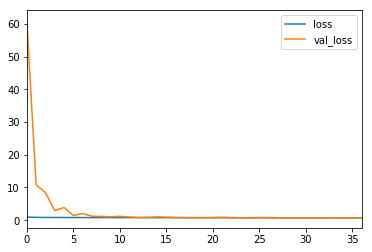

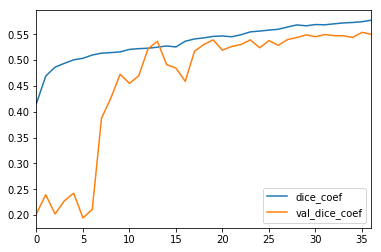

In [19]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [20]:
model.load_weights('model.h5')

In [21]:
def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [22]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

In [23]:
test_df = []
encoded_pixels = []
TEST_BATCH_SIZE = 500
best_threshold = 0.5
best_size = 25000

for i in range(0, test_images.shape[0], TEST_BATCH_SIZE):
    batch_idx = list(
        range(i, min(test_images.shape[0], i + TEST_BATCH_SIZE))
    )

    test_generator = DataGenerator(
        batch_idx,
        df=test_images,
        shuffle=False,
        mode='predict',
        dim=(350, 525),
        reshape=(320,480),
        n_channels=3,
        gamma=0.8,
#         graystyle=False,
        base_path='../input/understanding_cloud_organization/test_images',
        target_df=submission_df,
        batch_size=1,
        n_classes=4
    )

    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1
    ) 
    # Predict out put shape is (320X480X4)
    # 4  = 4 classes, Fish, Flower, Gravel Surger.
    
    for j, idx in enumerate(batch_idx):
        filename = test_images['ImageId'].iloc[idx]
        image_df = submission_df[submission_df['ImageId'] == filename].copy()
        
        # Batch prediction result set
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        
        image_df['EncodedPixels'] = pred_rles
        
        test_df.append(image_df)
        
        
        for k in range(pred_masks.shape[-1]):
            pred_mask = pred_masks[...,k].astype('float32') 
            
            if pred_mask.shape != (350, 525):
                pred_mask = cv2.resize(pred_mask, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
                
            pred_mask, num_predict = post_process(sigmoid(pred_mask), best_threshold, best_size )
            
            if num_predict == 0:
                encoded_pixels.append('')
            else:
                r = mask2rle(pred_mask)
                encoded_pixels.append(r)
        """
        # pred_rles = build_rles(pred_masks, reshape=(350, 525))

            #image_df['EncodedPixels'] = encoded_pixels
            #test_df.append(image_df)
        """

198/198 [==============================] - 21s 105ms/step


In [24]:
submission_df['EncodedPixels'] = encoded_pixels
submission_df.to_csv('submission.csv', columns=['Image_Label', 'EncodedPixels'], index=False)